In [1]:
%matplotlib inline

import sys
sys.path.append("../../ee595")
sys.path.append("../../IntegratedGradients")

import numpy as np
from deepsea import *

import seaborn as sns
import matplotlib.pyplot as plt

from IntegratedGradients import integrated_gradients
from keras.models import load_model

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [2]:
# data loading

test_X, test_Y = loaddata("../../ee595/data/deepsea/", "test")
train_X, train_Y = loaddata("../../ee595/data/deepsea/", "train")
valid_X, valid_Y = loaddata("../../ee595/data/deepsea/", "valid")

In [4]:
# get sample positions

temp = [i.rstrip().split("\t") for i in open("../allTFs.pos.bed").readlines()]
positions = [[i[0], int(i[1]), int(i[2]), i[3], i[4], i[5]] for i in temp]

In [4]:
# divide them into test valid train sets. 

trainpos = positions[0:2200000]
validpos = positions[2200000:2204000]
testpos = [i for i in positions[2204000:] if i[0] == "chr8" or i[0] == "chr9"]

In [13]:
# get which outputnode maps to GM12878, CTCF

description = [(i.split("\t")[2], i.split("\t")[1]) for i in open("../../ee595/data/deepsea/features.txt").readlines()[1:-1]]
indexes = [i for i in range(len(description)) if description[i][1] == "GM12878"]
#print description[2], "with index 2"

In [21]:
indexes = [i for i in range(len(description)) if description[i][1] == "GM12878"]

In [22]:
# hg 19 contigs

names = ["chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17_ctg5_hap1",
 "chr17","chr18","chr19","chr1","chr20","chr21","chr22","chr2","chr3","chr4_ctg9_hap1",
 "chr4","chr5","chr6_apd_hap1","chr6_cox_hap2","chr6_dbb_hap3","chr6","chr6_mann_hap4",
 "chr6_mcf_hap5","chr6_qbl_hap6","chr6_ssto_hap7","chr7","chr8","chr9","chrM","chrUn_gl000211",
 "chrUn_gl000212","chrUn_gl000213","chrUn_gl000214","chrUn_gl000215","chrUn_gl000216","chrUn_gl000217",
 "chrUn_gl000218","chrUn_gl000219","chrUn_gl000220","chrUn_gl000221","chrUn_gl000222","chrUn_gl000223",
 "chrUn_gl000224","chrUn_gl000225","chrUn_gl000226","chrUn_gl000227","chrUn_gl000228","chrUn_gl000229",
 "chrUn_gl000230","chrUn_gl000231","chrUn_gl000232","chrUn_gl000233","chrUn_gl000234","chrUn_gl000235",
 "chrUn_gl000236","chrUn_gl000237","chrUn_gl000238","chrUn_gl000239","chrUn_gl000240","chrUn_gl000241",
 "chrUn_gl000242","chrUn_gl000243","chrUn_gl000244",
 "chrUn_gl000245","chrUn_gl000246","chrUn_gl000247","chrUn_gl000248","chrUn_gl000249","chrX","chrY"]

sizes = [135534747,135006516,133851895,115169878,107349540,102531392,90354753,1680828,81195210,78077248,
         59128983,249250621,63025520,48129895,51304566,243199373,198022430,590426,191154276,180915260,4622290,
         4795371,4610396,171115067,4683263,4833398,4611984,4928567,159138663,146364022,141213431,16571,166566,
         186858,164239,137718,172545,172294,172149,161147,179198,161802,155397,186861,180455,179693,211173,15008,
         128374,129120,19913,43691,27386,40652,45941,40531,34474,41934,45867,39939,33824,41933,42152,43523,43341,
         39929,36651,38154,36422,39786,38502,155270560,59373566]

contigs = dict([(names[i], sizes[i]) for i in range(len(sizes))])

In [23]:
def loadarray(fileprefix, size):
    index = np.genfromtxt(fileprefix+"_index.csv", dtype=int)
    values = np.genfromtxt(fileprefix+"_values.csv", dtype=int)
    ret = np.zeros(size)
    for i in range(len(index)):
        ret[index[i]-1] = values[i]
    return ret

In [24]:
chroms = list(set([i[0] for i in positions]))

In [ ]:
#Loading ATACseq read starts (hyperbolilc arcsine transformation)

atacdata = {}
chrommax = {}
for c in chroms:
    temp = np.arcsinh(loadarray("ATAC-rep4/"+c, contigs[c]))
    atacdata[c] = temp
    chrommax[c] = np.max(temp)
    print c, ", AVG asinh transformed coverage:", np.max(temp)

chrY , AVG asinh transformed coverage: 9.90048304603
chrX , AVG asinh transformed coverage: 9.22345402086
chr13 , AVG asinh transformed coverage: 9.58520881083
chr12 , AVG asinh transformed coverage: 9.29999825227
chr11 , AVG asinh transformed coverage: 10.3017266167
chr10 , AVG asinh transformed coverage: 6.03548715579
chr17 , AVG asinh transformed coverage: 9.90338755004
chr16 , AVG asinh transformed coverage: 5.95584408099


In [11]:
atactrain = [] 
for i in trainpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    atactrain.append(sample)
atactrain = np.array(atactrain)

81194400 81195400 chr17
81194600 81195600 chr17


In [19]:
atacvalid = [] 
for i in validpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    atacvalid.append(sample)
atacvalid = np.array(atacvalid)

In [21]:
atactest = [] 
for i in testpos:
    temp = atacdata[i[0]][i[1]-400:i[2]+400]
    if temp.shape[0] != 1000:
        print i[1]-400, i[2]+400, i[0]
        sample = np.zeros((1000, 1))
        for j in range(len(temp)):
            sample[j,0] = temp[j]
    else:
        sample =  temp.reshape((1000,1))
        
    sample = sample/chrommax[i[0]]
    atactest.append(sample)
atactest = np.array(atactest)

In [22]:
np.save("atactrain", atactrain)

In [23]:
np.save("atacvalid", atacvalid)

In [26]:
np.save("atactest", atactest)

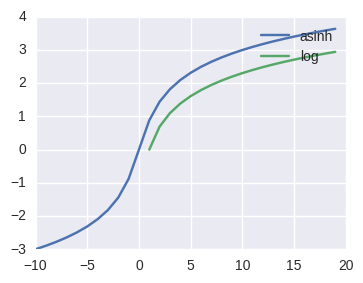

In [27]:
# Sample distribution of asinh and log transformation 

plt.figure(figsize=(4,3))
m = 20
plt.plot(range(-10, m), np.arcsinh(range(-10, m)), label="asinh")
plt.plot(range(-10, m), np.log(range(-10, m)), label="log")
plt.legend()

# visualization

In [31]:
dsmodel = load_model("../../ee595/models/deepsea/weights-improvement-09-0.06-full.hdf5")

In [32]:
ig = integrated_gradients(dsmodel, [2], verbose=0)

chr1
chr1
chr11
chr11
chr11
chr11
chr11
chr13
chr2
chr2
chr3


/home/hiranumn/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


chr3
chr4
chr5
chr5
chr6
chr6


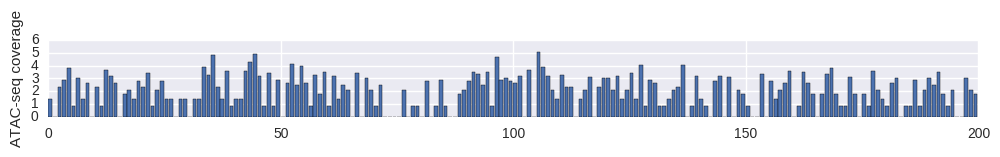

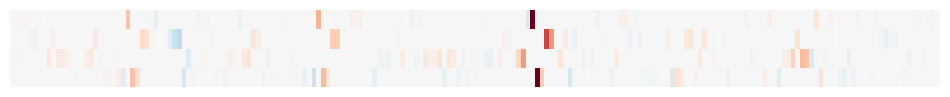

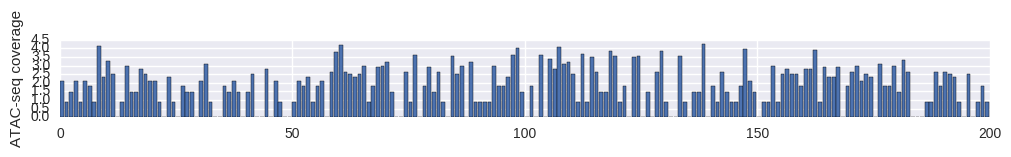

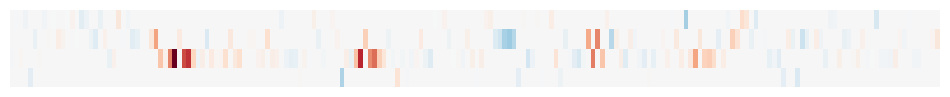

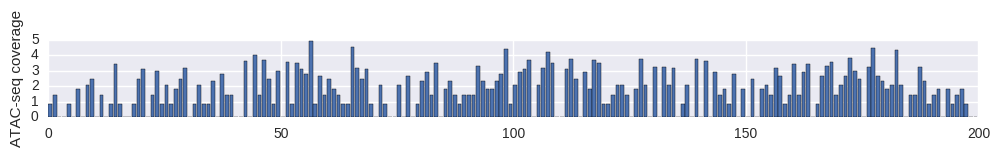

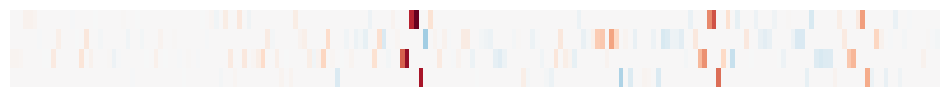

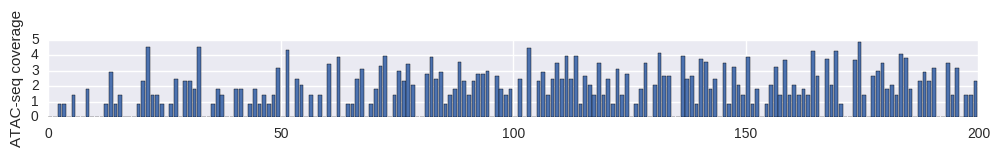

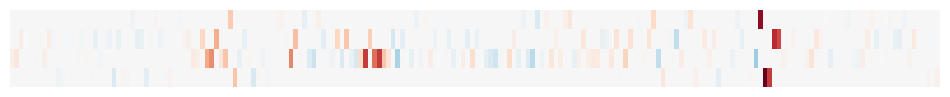

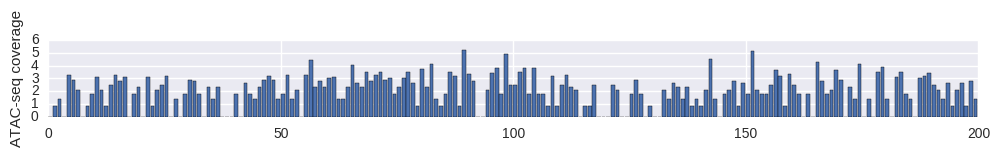

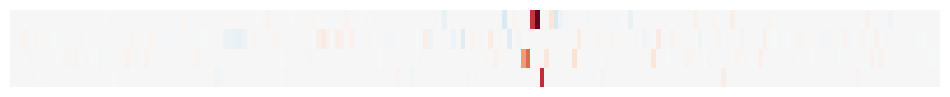

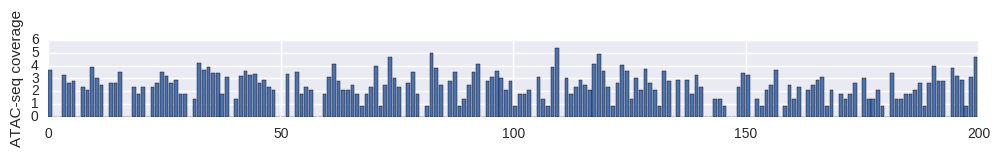

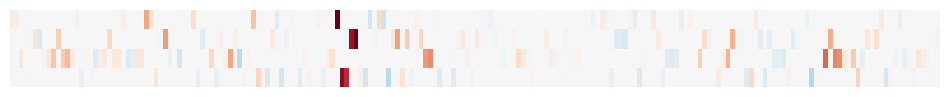

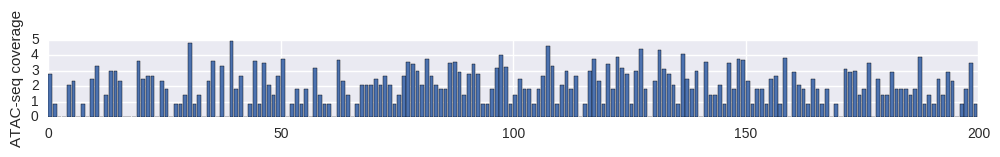

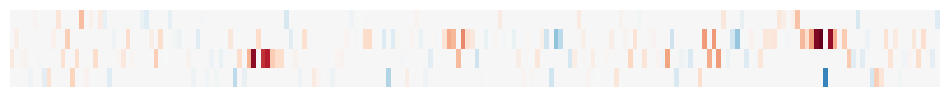

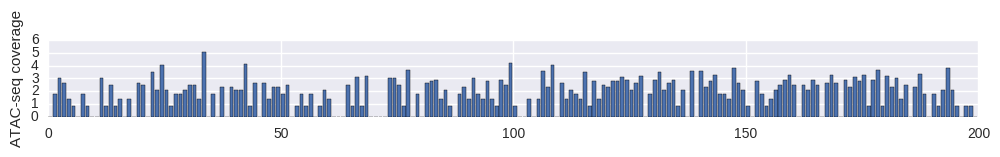

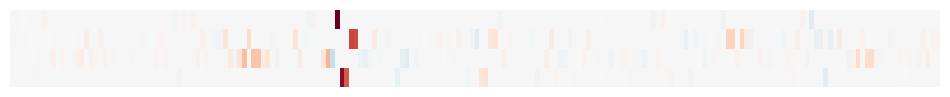

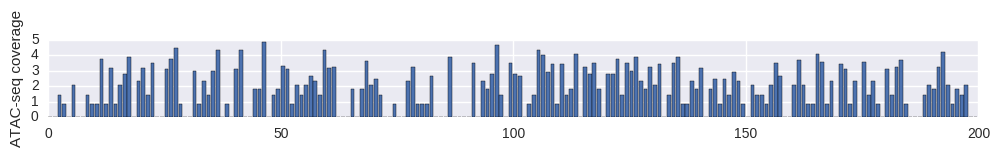

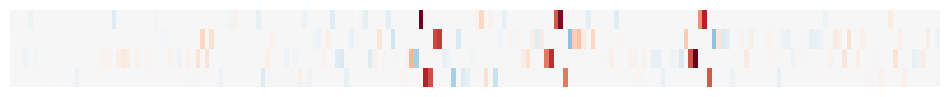

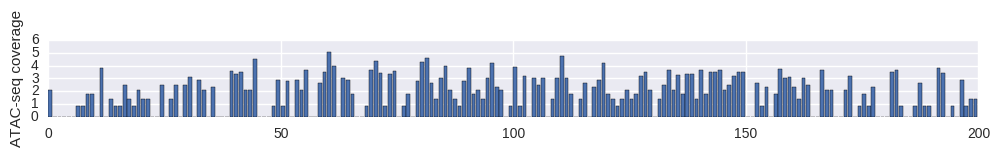

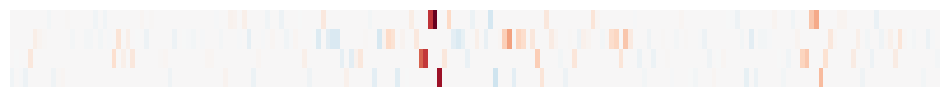

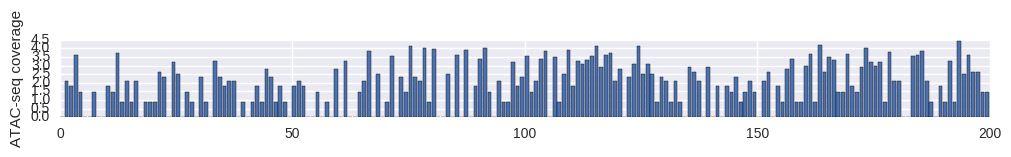

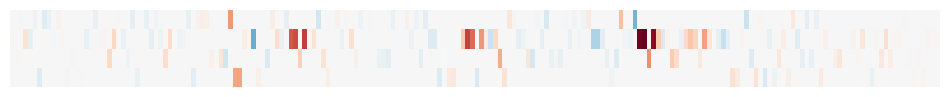

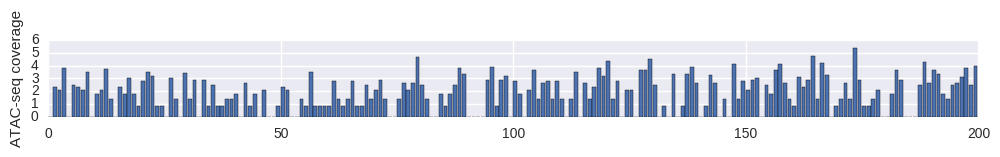

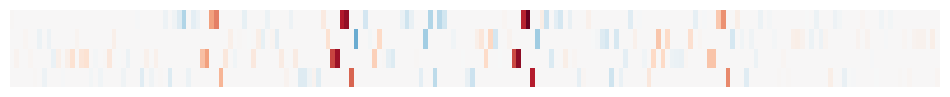

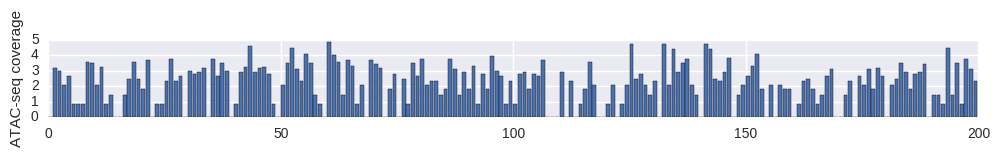

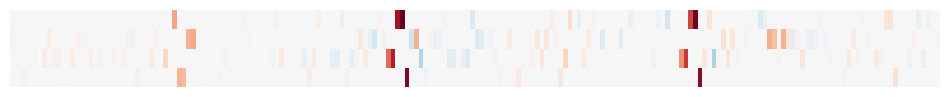

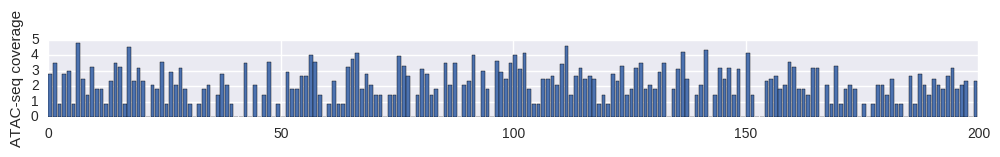

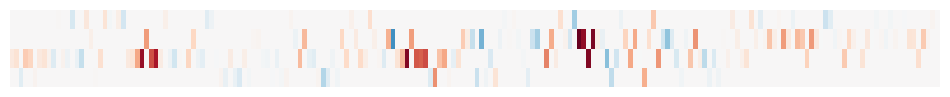

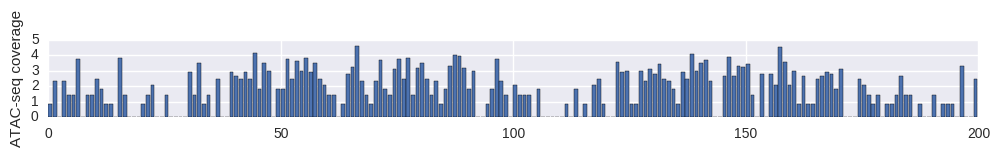

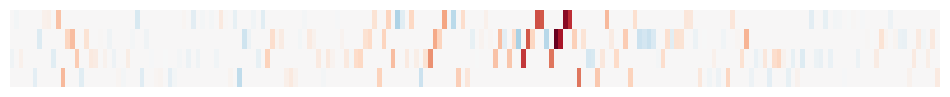

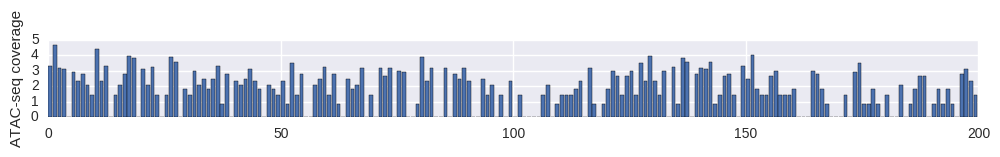

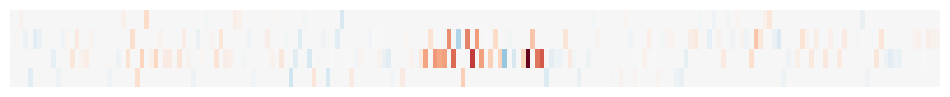

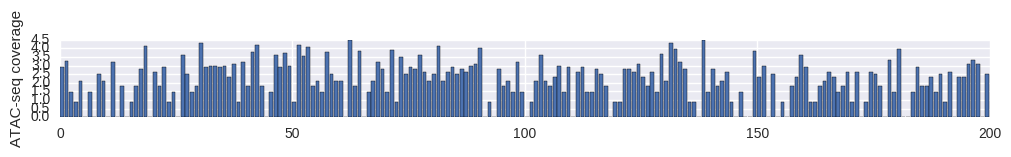

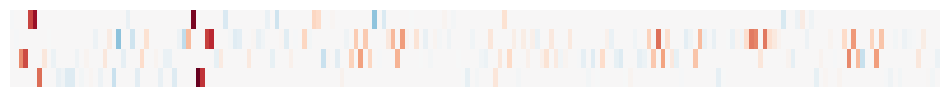

In [44]:
for i in index:
    pos = trainpos[i]
    if sum(atacdata[pos[0]][pos[1]:pos[2]]) > 350:
        plt.figure(figsize=(12,1))
        plt.ylabel("ATAC-seq coverage")
        plt.bar(range(200), atacdata[pos[0]][pos[1]:pos[2]])
        ex = ig.explain(train_X[i])[0][400:600]
        plt.figure(figsize=(12,1))
        sns.heatmap(np.transpose(ex), cbar=False)
        plt.yticks([],[])
        plt.xticks([],[])